## Import Libraries

In [66]:
# Importing Libraries
from glob import glob
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
from scipy import stats
from scipy.stats import skew, kurtosis


import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, DepthwiseConv2D, SeparableConv2D, AveragePooling2D, Dropout, Flatten, Dense, concatenate, LeakyReLU
from tensorflow.keras.utils import to_categorical
from keras.constraints import max_norm
from keras.layers import Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

## Data Loading and Preprocessing

In [67]:
# Storing file paths
all_file_path = glob("/kaggle/input/main-eeg/eeg-during-mental-arithmetic-tasks-1.0.0/*.edf")

In [68]:
# No. of files found
len(all_file_path)

72

In [69]:
# Separate file paths for rest and task
rest_file_path = [i for i in all_file_path if '1' in i.split('_')[1]]
task_file_path = [i for i in all_file_path if '2' in i.split('_')[1]]

In [70]:
# Initialize empty lists to hold the raw data
raw_rest_list = []
raw_task_list = []

In [71]:
%%capture
# Load rest files
for file_path in rest_file_path:
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw_rest_list.append(raw)

In [72]:
# Concatenate rest files
raw_rest = mne.concatenate_raws(raw_rest_list)

In [73]:
%%capture
# Load task files
for file_path in task_file_path:
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw_task_list.append(raw)

In [74]:
# Concatenate task files
raw_task = mne.concatenate_raws(raw_task_list)

In [75]:
# Display info
print(raw_rest.info)
print(raw_task.info)

<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG Fp2, EEG F3, EEG F4, EEG F7, EEG F8, EEG T3, EEG ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2010-01-01 00:00:00 UTC
 nchan: 21
 projs: []
 sfreq: 500.0 Hz
 subject_info: 4 items (dict)
>
<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG Fp2, EEG F3, EEG F4, EEG F7, EEG F8, EEG T3, EEG ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2010-01-01 00:00:00 UTC
 nchan: 21
 projs: []
 sfreq: 500.0 Hz
 subject_info: 4 items (dict)
>


In [76]:
# Function to read and preprocess data
def read_data(file_path):
    data = mne.io.read_raw_edf(file_path, preload = True)
    data.set_eeg_reference()
    #data.filter(l_freq = 0.5, h_freq = 45)
    epochs = mne.make_fixed_length_epochs(data, duration = 5, overlap = 1)
    array = epochs.get_data()
    return array

In [77]:
# Display info about the loaded data
sample_data = read_data(rest_file_path[0])

Extracting EDF parameters from /kaggle/input/main-eeg/eeg-during-mental-arithmetic-tasks-1.0.0/Subject26_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped


In [78]:
sample_data.shape # no of epochs, channels and length of signal

(45, 21, 2500)

In [79]:
%%capture
# Load all rest and task epochs data
rest_epochs_array = [read_data(i) for i in rest_file_path]
task_epochs_array = [read_data(i) for i in task_file_path]

In [80]:
rest_epochs_array[0].shape

(45, 21, 2500)

In [81]:
# Create labels for rest and task epochs
rest_epochs_labels = [len(i)*[0] for i in rest_epochs_array] # 0 for rest 
task_epochs_labels = [len(i)*[1] for i in task_epochs_array] # 1 for task

In [82]:
len(rest_epochs_labels), len(task_epochs_labels)

(36, 36)

In [83]:
# Combine data and labels into lists
data_list = rest_epochs_array + task_epochs_array
label_list = rest_epochs_labels + task_epochs_labels

In [84]:
# Create groups for each subject
group_list = [[i]*len(j) for i, j in enumerate(data_list)]
len(group_list)

72

In [85]:
# Convert lists to arrays for model training
data_array = np.vstack(data_list)
label_array = np.hstack(label_list)
group_array = np.hstack(group_list)

In [86]:
data_array.shape, label_array.shape, group_array.shape

((2132, 21, 2500), (2132,), (2132,))

## Power Spectral Density (PSD) Analysis

In [87]:
# Define frequency bands
bands = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 100)}

In [88]:
# Compute PSD for rest state using Welch's method
spectrum_rest = raw_rest.compute_psd(method='welch', fmin=1, fmax=100, n_fft=2048)
psds_rest, freqs_rest = spectrum_rest.get_data(return_freqs=True)

Effective window size : 4.096 (s)


In [89]:
# Compute PSD for task state using Welch's method
spectrum_task = raw_task.compute_psd(method='welch', fmin=1, fmax=100, n_fft=2048)
psds_task, freqs_task = spectrum_task.get_data(return_freqs=True)

Effective window size : 4.096 (s)


In [90]:
# Function to calculate band power
def bandpower(psds, freqs, band):
    band_freqs = np.logical_and(freqs >= band[0], freqs <= band[1])
    band_power = np.mean(psds[:, band_freqs], axis=1)
    return band_power

# Calculate band powers
band_powers_rest = {band: bandpower(psds_rest, freqs_rest, freq_range) for band, freq_range in bands.items()}
band_powers_task = {band: bandpower(psds_task, freqs_task, freq_range) for band, freq_range in bands.items()}

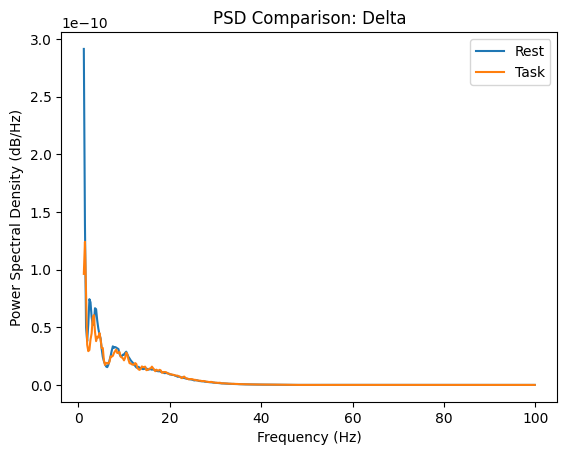

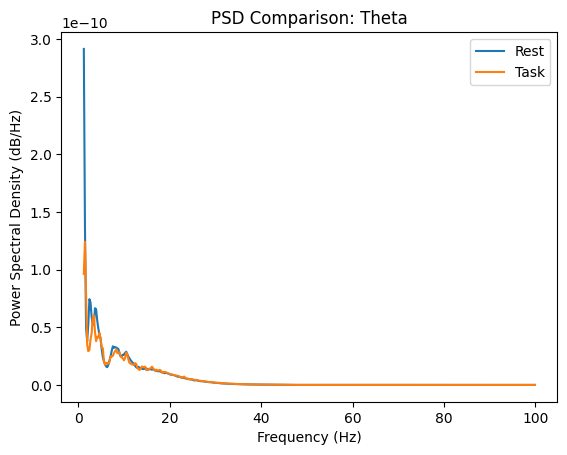

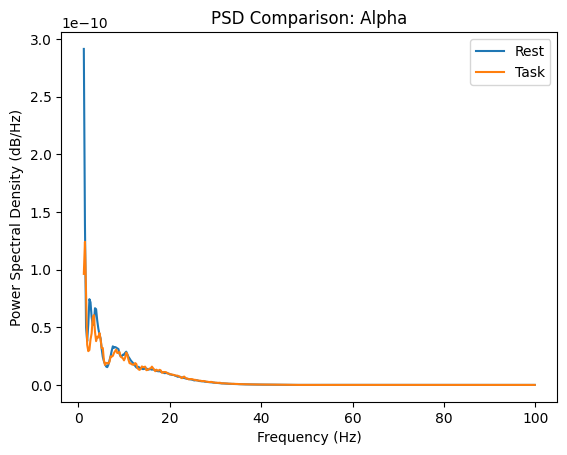

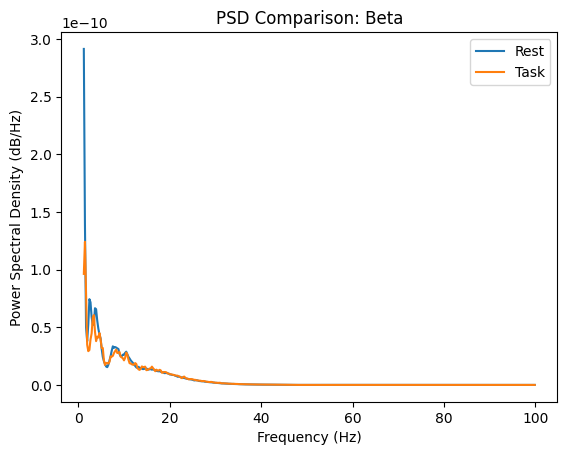

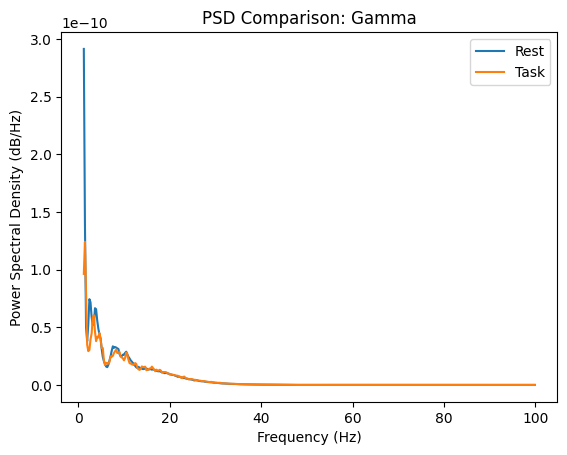

In [91]:
# Plot PSD comparison
for band in bands:
    plt.figure()
    plt.title(f'PSD Comparison: {band}')
    plt.plot(freqs_rest, np.mean(psds_rest, axis=0), label='Rest')
    plt.plot(freqs_task, np.mean(psds_task, axis=0), label='Task')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    plt.legend()
    plt.show()


## Feature Extraction

In [92]:
# Define functions for feature extraction
def mean(x):
    return np.mean(x,axis=-1)
def std(x):
    return np.std(x,axis=-1)
def ptp(x):
    return np.ptp(x,axis=-1)
def var(x):
    return np.var(x,axis=-1)
def minim(x):
    return np.min(x,axis=-1)
def maxim(x):
    return np.max(x,axis=-1)
def argminim(x):
    return np.argmin(x,axis=-1)
def argmaxim(x):
    return np.argmax(x,axis=-1)
def mean_square(data):
      return np.mean(data**2,axis=-1)
def rms(x):
    return np.sqrt(np.mean(x**2,axis=-1))
def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=-1)),axis=-1)
def skewness(data):
    return stats.skew(data,axis=-1)
def kurtosis(data):
    return stats.kurtosis(data,axis=-1)

def concatenate_features(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),argminim(data),argmaxim(data),
                          mean_square(data),rms(data),abs_diffs_signal(data),
                          skewness(data),kurtosis(data)),axis=-1)

In [93]:
# Extract features for each epoch
from tqdm import tqdm_notebook
features=[]
for data in tqdm_notebook(data_array):
    features.append(concatenate_features(data))
features=np.array(features)
features.shape

/tmp/ipykernel_34/3783067424.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(data_array):


  0%|          | 0/2132 [00:00<?, ?it/s]

(2132, 273)

## Model Training

Splitting and reshaping data

In [94]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_array, label_array, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Add a channel dimension for CNN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [95]:
X_train.shape, y_train.shape

((1705, 21, 2500, 1), (1705,))

## EEGNet Model

In [96]:
def EEGNet(nb_classes, Chans=21, Samples=2500, dropoutRate=0.5, kernLength=512, F1=8, D=2, F2=16, norm_rate=0.25):
    input1 = Input(shape=(Chans, Samples, 1))

    ##################################################################
    block1 = Conv2D(F1, (1, kernLength), padding='same',
                    input_shape=(Chans, Samples, 1),
                    use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False,
                             depth_multiplier=D,
                             depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 20))(block1)  # Increased pooling size
    block1 = Dropout(dropoutRate)(block1)

    ##################################################################
    block2 = SeparableConv2D(F2, (1, 128),  # Increased kernel length
                             use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 40))(block2)  # Increased pooling size
    block2 = Dropout(dropoutRate)(block2)

    flatten = Flatten(name='flatten')(block2)

    dense = Dense(nb_classes, name='dense',
                  kernel_constraint=max_norm(norm_rate))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

In [97]:
# Define Early Stopping criteria
es = EarlyStopping(monitor = 'val_loss', patience = 2, min_delta = 0.01)

In [98]:
# Initialize EEGNet model
nb_classes = 2
model = EEGNet(nb_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks = [es])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
 3/54 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5434 - loss: 0.7045

I0000 00:00:1720374768.469333     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - accuracy: 0.7089 - loss: 0.6368 - val_accuracy: 0.7377 - val_loss: 0.6141
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7539 - loss: 0.5339 - val_accuracy: 0.7424 - val_loss: 0.5388
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7739 - loss: 0.4805 - val_accuracy: 0.7752 - val_loss: 0.4945
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7939 - loss: 0.4638 - val_accuracy: 0.7658 - val_loss: 0.4606
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7891 - loss: 0.4782 - val_accuracy: 0.7728 - val_loss: 0.4454
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8076 - loss: 0.4404 - val_accuracy: 0.8033 - val_loss: 0.4258
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8267 - loss: 0.4242 - val_accuracy: 0.8220 - val_loss: 0.4092
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8157 - loss: 0.4365 - val_accuracy: 0.8197 - val_loss: 

In [99]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8459 - loss: 0.3703
Test Loss: 0.3718580901622772, Test Accuracy: 0.8337236642837524


In [100]:
# Predict the classes for test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate and print the classification report
report = classification_report(y_test, y_pred_classes, target_names=['Rest', 'Task'])
print(report)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
              precision    recall  f1-score   support

        Rest       0.83      0.97      0.90       315
        Task       0.86      0.44      0.58       112

    accuracy                           0.83       427
   macro avg       0.84      0.71      0.74       427
weighted avg       0.84      0.83      0.81       427



## TSception Model

In [101]:
# Define the time-domain convolution block
def conv_block(input, out_chan, kernel, step, pool):
    x = Conv2D(out_chan, kernel, strides=step, padding='same', use_bias=False)(input)
    x = LeakyReLU()(x)
    x = AveragePooling2D(pool_size=(1, pool), strides=(1, pool))(x)

    return x

def Tsception(num_classes, Chans, Samples, sampling_rate, num_T, num_S, hidden, dropout_rate, pool=8):
    '''
    Input:
    - num_classes: Number of classes for classification.
    - Chans: Number of channels in the input data.
    - Samples: Number of time samples in the input data.
    - sampling_rate: Sampling rate of the input data.
    - num_T: Number of filters in the time-domain convolution blocks.
    - num_S: Number of filters in the spatial-domain convolution blocks.
    - hidden: Number of neurons in the fully connected hidden layer.
    - dropout_rate: Dropout rate for regularization.
    - pool: Pooling factor for average pooling operations.

    Output:
    - Model: A Keras Model instance.

    Description:
    Constructs a Tsception model architecture based on the parameters provided.
    '''

    inception_window = [0.5, 0.25, 0.125]
    
    # Define input layer
    input = Input(shape=(Chans, Samples, 1))
    
    # Define time-domain convolution blocks
    x1 = conv_block(input, num_T, (1, int(sampling_rate * inception_window[0])), 1, pool)
    x2 = conv_block(input, num_T, (1, int(sampling_rate * inception_window[1])), 1, pool)
    x3 = conv_block(input, num_T, (1, int(sampling_rate * inception_window[2])), 1, pool)
    
    # Concatenate along the height dimension
    x = concatenate([x1, x2, x3], axis=2)
    x = BatchNormalization()(x)
    
    # Define spatial-domain convolution blocks
    y1 = conv_block(x, num_S, (Chans, 1), (Chans, 1), int(pool*0.25))
    y2 = conv_block(x, num_S, (int(Chans*0.5), 1), (int(Chans*0.5), 1), int(pool*0.25))
    
    # Concatenate along the width dimension
    y = concatenate([y1, y2], axis=1)
    y = BatchNormalization()(y)
    
    # Define fusion layer
    z = conv_block(y, num_S, (3, 1), (3, 1), 4)
    z = BatchNormalization()(z)
    
    # Global average pooling layer
    z = AveragePooling2D(pool_size=(1, z.shape[2]))(z)
    z = Flatten()(z)
    
    # Fully connected layers
    z = Dense(hidden, activation='relu', use_bias=False)(z)
    z = Dropout(dropout_rate)(z)
    z = Dense(num_classes, activation='softmax', use_bias=False)(z)

    return Model(inputs=input, outputs=z)

if __name__ == '__main__':
    model = Tsception(num_classes=2, Chans=21, Samples=2500, sampling_rate=500, num_T=64, num_S=32, hidden=32, dropout_rate=0.5)
    model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 21, 2500,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 21, 2500,  │     16,000 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 21, 2500,  │      8,000 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 21, 2500,  │      3,968 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 21, 2500,  │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 21, 2500,  │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 21, 2500,  │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_4 │ (None, 21, 312,   │          0 │ leaky_re_lu[0][0] │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_5 │ (None, 21, 312,   │          0 │ leaky_re_lu_1[0]… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_6 │ (None, 21, 312,   │          0 │ leaky_re_lu_2[0]… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 21, 936,   │          0 │ average_pooling2… │
│ (Concatenate)       │ 64)               │            │ average_pooling2… │
│                     │                   │            │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 936,   │        256 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 1, 936,    │     43,008 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 3, 936,    │     20,480 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 1, 936,    │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 3, 936,    │          0 │ conv2d_6[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 97,152 (379.50 KB)

 Trainable params: 96,896 (378.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [102]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [103]:
# Define Early Stopping criteria
es = EarlyStopping(monitor = 'val_loss', patience = 4, min_delta = 0.01)

In [104]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks = [es])

Epoch 1/10


2024-07-07 17:53:35.592045: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,1,1,250]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,21,2501]{3,2,1,0}, f32[32,64,21,2500]{3,2,1,0}), window={size=1x250 pad=0_0x124_124}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-07 17:53:35.653245: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.061307003s
Trying algorithm eng0{} for conv (f32[64,1,1,250]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,21,2501]{3,2,1,0}, f32[32,64,21,2500]{3,2,1,0}), window={size=1x250 pad=0_0x124_124}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-07 17:53:37.130700:

54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 263ms/step - accuracy: 0.7259 - loss: 0.5913 - val_accuracy: 0.7377 - val_loss: 0.5804
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.7649 - loss: 0.4904 - val_accuracy: 0.7377 - val_loss: 0.5269
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.7884 - loss: 0.4548 - val_accuracy: 0.7377 - val_loss: 0.5969
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.7952 - loss: 0.4332 - val_accuracy: 0.7377 - val_loss: 0.5304
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.8199 - loss: 0.3856 - val_accuracy: 0.7775 - val_loss: 0.4496
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.8663 - loss: 0.3142 - val_accuracy: 0.8478 - val_loss: 0.3429
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.8622 - loss: 0.3104 - val_accuracy: 0.8431 - val_loss: 0.3689
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.8881 - loss: 0.2734 - val_accuracy: 0.8923 - val_loss: 

In [105]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9081 - loss: 0.2176
Test Loss: 0.21523411571979523, Test Accuracy: 0.9133489727973938


In [106]:
# Predict the classes for test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate and print the classification report
report = classification_report(y_test, y_pred_classes, target_names=['Rest', 'Task'])
print(report)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
              precision    recall  f1-score   support

        Rest       0.92      0.97      0.94       315
        Task       0.89      0.77      0.82       112

    accuracy                           0.91       427
   macro avg       0.90      0.87      0.88       427
weighted avg       0.91      0.91      0.91       427

